# Setup (imports & others)

In [ ]:
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.13.1+cu116.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.1+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 56.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 52.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.4/868.4 KB 49.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 616.2/616.2 KB 10.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.3.0-py3-none-any.whl size=909897 sha256=f17f32c5db9b071e4c79ac6249d5964fef302cf26e194e697a039b544f02a945
  Stored in directory: /root/.cache/pip/wheels/cd/7d/6b/17150450b80b4a3656a84330e22709ccd8dc0f8f4773ba4133
Successfully built torch

In [ ]:
import torch

from torch import nn
from torch import optim
from torch.nn import functional as F

import networkx as nx

import torch_geometric as tg
import torch_geometric.nn as gnn
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Dataset
from torch_geometric.loader import DataLoader
from torch_geometric import transforms as T
from torch_geometric.nn.models import LabelPropagation

from torch_scatter import scatter

import matplotlib.pyplot as plt
%matplotlib inline

from typing import Tuple, Iterable, List, Union

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using the following device: {device}')

Using the following device: cuda


In [ ]:
class SelectY:
    """
    This transforms enables us to pre-process datasets by
    selecting which labels we want to keep.
    """

    def __init__(self, targets: Union[List[int], int]):
        """
        Parameters
        ----------
        - `targets`: a list of integers or an integer describing the target
        labels to keep.
        """
        assert targets if hasattr(targets, '__len__') else targets >= 0 
        self.targets = targets

    def __call__(self, data):
        data.y = data.y[:, self.targets]
        return data

Below is a utility function to save our results as a pickle file, so that we can make nicer plots in a separate file.

In [ ]:
import pickle


def export_pickled(data, path: str):
    """
    Performs a pickle dump of `data` into file at `path`.
    """
    assert path

    with open(path, 'wb+') as f:
        pickle.dump(data, f)

In [ ]:
from os import mkdir

mkdir('./out/')

# Our models/layers

## No-T

No-T centers all points by subtracting their centroids batch-wise, which makes the following layers $\mathsf{T}(n)$-invariant.

In [ ]:
class NoTLayer(nn.Module):
    """
    This layer allows to centre all points batch-wise by their centroids,
    enabling thus `T(n)` invariance.
    """

    def forward(self, x, batch):
        """
        Computes batch-wise centroids of `x` and centers
        all points by the centroids.

        Parameters
        ----------
        - `x`: must be of shape `B x V x D`, where `B` is the number of batches,
        `V` is the number of nodes and `D` the number of dimensions;
        
        - `batch`: contains the indices of the batches.
        """
        
        centroids = scatter(x, index=batch, dim=0, reduce='mean')
        # we now have batch-wise centroids
        # apply them per batch
        batches = torch.unique(batch)
        for b in batches:
            x[batch == b] -= centroids[b]
        return x

## Coul-NN layer
We define here a single CoulNN layer, the formula of which is given by:
$$
\renewcommand{\vh}{\mathbf{h}}
\renewcommand{\vx}{\mathbf{x}}
\renewcommand{\mWneigh}{\mathbf{W}_{\mathrm{a}}}
\renewcommand{\mWself}{\mathbf{W}_{\mathrm{s}}}
\renewcommand{\neigh}{\mathcal{N}}
\vh_{u, \mathrm{a}}^{(t + 1)} = \sum_{v \in \neigh(u)} \varphi_1^{(t)} \left(\vh_u^{(t)} \middle\Vert \vh_v^{(t)} \middle\Vert \cos\left(\vx_u', \vx_v'\right) \middle\Vert \lVert{\vx_{v\to u}'}\rVert^{2} \right), \\
\vh_u^{(t + 1)} = \sigma\left(\varphi_2^{(t)}\left(\vh_u^{(t)}, \vh_{u, \mathrm{a}}^{(t + 1)}\right)\right).
$$

In [ ]:
class CoulNNLayer(MessagePassing):
    def __init__(self, in_dim=32, out_dim=32, aggr='add'):
        """
        Parameters
        ----------
        - `in_dim`: the input dimension of the features;
        - `out_dim`: the output dimension of the features;
        - `aggr`: the aggregation style.
        """
        super().__init__(aggr=aggr)
        self.mlp_msg = nn.Linear(2 * in_dim + 2, in_dim)
        self.upd_mlp = nn.Linear(2 * in_dim, out_dim)

    def forward(self, h, pos, edge_index):
        return self.propagate(edge_index, h=h, pos=pos)

    def message(self, h_i, h_j, pos_i, pos_j):
        dists = torch.sum(torch.square((pos_j - pos_i)), dim=1).unsqueeze(-1)
        # cos similarity = cos
        coses = F.cosine_similarity(pos_i, pos_j, dim=-1).unsqueeze(-1)
        # out
        return self.mlp_msg(torch.cat([h_i, h_j, coses, dists], dim=-1))
    
    def aggregate(self, inputs, index):
        return scatter(inputs, index, dim=self.node_dim, reduce=self.aggr)
    
    def update(self, aggr_out, h):
        return self.upd_mlp(torch.cat([h, aggr_out], dim=-1))

## EGNN layer

We re-implement the EGNN described in (Satorras et al., 2022). (In this case, making it invariant, since we do not update coordinates.) Observe that we also add ELU activations between all two layers.

*Note: this code is based on the one done for Practical 3.*



In [ ]:
class EGNNLayer(MessagePassing):
    def __init__(self, in_dim=32, out_dim=32, aggr='add'):
        """
        Parameters
        ----------
        - `in_dim`: the input dimension of the features;
        - `out_dim`: the output dimension of the features;
        - `aggr`: the aggregation style.
        """
        super().__init__(aggr=aggr)
        self.mlp_msg = nn.Linear(2 * in_dim, in_dim)
        self.mlp_upd = nn.Linear(2 * in_dim, out_dim)

    def forward(self, h, pos, edge_index):
        return self.propagate(edge_index, h=h, pos=pos)

    def message(self, h_i, h_j, pos_i, pos_j):
        dists = torch.sum(torch.square((pos_j - pos_i)), dim=1).unsqueeze(-1)
        h_i = dists * h_i
        h_j = dists * h_j
        return self.mlp_msg(torch.cat([h_i, h_j], dim=-1))
    
    def aggregate(self, inputs, index):
        return scatter(inputs, index, dim=self.node_dim, reduce=self.aggr)
    
    def update(self, aggr_out, h):
        upd_out = torch.cat([h, aggr_out], dim=-1)
        return self.mlp_upd(upd_out)


class EGNNModel(nn.Module):
    def __init__(self, num_layers=3, emb_dim=32, in_dim=11, out_dim=1):
        """
        Parameters
        ----------
        - `num_layers`: the number of layers;
        - `emb_dim`: the hidden dimension;
        - `in_dim`: the initial number of features;
        - `out_dim`: the output dimension.
        """

        super().__init__()

        self.gnn = gnn.Sequential('x, pos, edge_index', [
            l for i in range(num_layers) for l in [
                (EGNNLayer(in_dim if i == 0 else emb_dim, emb_dim), 'x, pos, edge_index -> x'),
                nn.ELU(),
            ]
        ])
        self.pool = gnn.global_add_pool
        self.lin_pred = nn.Linear(emb_dim, out_dim)

    def forward(self, x, pos, edge_index, batch):
        h = self.gnn(x, pos, edge_index)
        h_graph = self.pool(h, batch)
        out = self.lin_pred(h_graph)
        return out

## Label Propagation

We use Torch Geometric's `LabelPropagation` class for standard label propagation. Below, we define $\mathsf{CoulLP}$, the equation of which is given by
$$
\vh_u^{(t + 1)} = \sum_{v \in \neigh(u)} \frac{\cos(\vh_u^{(t)}, \vh_v^{(t)})} {\sqrt{\deg(u) \deg(v)}} \vh_v^{(t)}.
$$

**Note**: the initialisation to equiprobable labels is crucial, as otherwise, using one-hot encoding, labels become orthogonal---in which case the aggregation becomes (quasi-)trivial.

In [ ]:
from torch_geometric.typing import Adj, OptTensor


class CoulLP(LabelPropagation):
    # Note: We copy-paste here the code from the super-class to change one
    # specific line about the initialisation.
    @torch.no_grad()
    def forward(
        self,
        y: torch.Tensor,
        edge_index: Adj,
        mask: OptTensor = None,
        edge_weight: OptTensor = None,
    ) -> torch.Tensor:
        if y.dtype == torch.long and y.size(0) == y.numel():
            y = F.one_hot(y.view(-1))

        out = y
        if mask is not None:
            out = torch.ones_like(y) / y.shape[-1]
            out[mask] = y[mask].float()

        
        edge_index, edge_weight = gnn.conv.gcn_conv.gcn_norm(edge_index, num_nodes=y.size(0),
                                               add_self_loops=False)

        res = (1 - self.alpha) * out
        for _ in range(self.num_layers):
            out = self.propagate(edge_index, x=out, edge_weight=edge_weight,
                                 size=None)
            out.mul_(self.alpha).add_(res)

        return out

    def message(self, x_i, x_j, edge_weight) -> torch.Tensor:
        return F.cosine_similarity(x_i, x_j, dim=-1).unsqueeze(-1) * (edge_weight.view(-1, 1) * x_j)

# Experiments

In [ ]:
class RegressionResult:
    """
    Data class to store results from regression for a given model.
    """

    def __init__(self, name: str, mae: List[float]):
        """
        Parameters
        ----------
        - `name`: name of the model;
        - `mae`: list of the MAEs per epoch.
        """
        self.name = name
        self.mae = mae

## QM9

We evaluate our models on the targets $0$ ($\mu$, dipole moment), $1$ ($\alpha$, isotropic polarisability), and $5$ ($\langle R^2 \rangle$, electronic spatial extent).

*Note: we re-use some of the code from Practical 3 for this part of the notebook.*

*Note 2: the run included in the paper's PDF may not be the ones just below.*

In [ ]:
from torch_geometric.datasets import QM9


qm_dataset = QM9(root='./data/qm9')
print('Loaded QM9 dataset.')


# Key: task -> model name -> Regression Result
qm_results = {}

Loaded QM9 dataset.


In [ ]:
def train_regression_task(model: nn.Module, criterion, optimizer, epochs: int, train_data: DataLoader, test_data: DataLoader, p_ep=5):
    """
    Trains the provided model `model` for a regression task.

    Returns a list of MAEs per epoch.
    """

    def test_mae():
        """
        Computes and returns the MAE of the model over the test data.
        """
        model.eval()
        losses = []
        for data in test_data:
            data = data.to(device)
            out = model(data.x, data.pos, data.edge_index, data.batch).squeeze()
            mae = F.l1_loss(out, data.y)
            losses += [mae.cpu().detach().numpy()]

        return sum(losses) / len(losses)
            

    def train_epoch():
        """
        Trains the model for exactly one epoch.
        """
        model.train()
        for data in train_data:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data.x, data.pos, data.edge_index, data.batch).squeeze()
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()


    print('Training and evaluating the following model: ')
    print(model)
    print('---------------------------------------------')

    perfs = []

    for epoch in range(epochs):
        train_epoch()
        perfs += [test_mae()]
        if epoch % p_ep == 0:
            print(f'---- Last epoch {epoch + 1}/{epochs}, MAE: {perfs[-1]:.5f}')

    return perfs

In [ ]:
def qm_eval_model(name: str, model: nn.Module, task: int):
    """
    Trains the provided model `model`, and stores its results
    in `qm_results` under the name `name`.
    """
    assert name
    assert model
    assert task >= 0

    qm_dataset = QM9(root='./data/qm9', transform=T.Compose([ SelectY( task ) ]))
    qm_dataset = qm_dataset.shuffle()
    train_data = qm_dataset[:5000]
    test_data = qm_dataset[5000:7500]
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
    test_loader = DataLoader(train_data, batch_size=32, shuffle=False)

    p = train_regression_task(
        model, 
        nn.L1Loss(), 
        optim.Adam(model.parameters(), lr=0.001), 
        50,
        train_loader, 
        test_loader
    )

    if task not in qm_results:
        qm_results[task] = {}

    qm_results[task][name] = RegressionResult(name, p)
    print(f'Done for {name} on task {task}!')

First, we evaluate the normal GCN:

In [ ]:
def qm_normal_gcn(task):
    """Trains and evaluates the normal GCN"""
    model = gnn.Sequential('x, pos, edge_index, batch', [
        (gnn.GCNConv(qm_dataset.num_features, 32), 'x, edge_index -> x'),
        nn.ELU(),

        (gnn.GCNConv(32, 32), 'x, edge_index -> x'),
        nn.ELU(),

        (gnn.GCNConv(32, 32), 'x, edge_index -> x'),
        nn.ELU(),

        (gnn.global_add_pool, 'x, batch -> x'),
        (nn.Linear(32, 1), 'x -> x'),
    ]).to(device)
    qm_eval_model('GCN', model, task)


qm_normal_gcn(0)

Training and evaluating the following model: 
Sequential(
  (0): GCNConv(11, 32)
  (1): ELU(alpha=1.0)
  (2): GCNConv(32, 32)
  (3): ELU(alpha=1.0)
  (4): GCNConv(32, 32)
  (5): ELU(alpha=1.0)
  (6): <function global_add_pool at 0x7fe03d00b1f0>
  (7): Linear(in_features=32, out_features=1, bias=True)
)
---------------------------------------------
---- Last epoch 1/50, MAE: 1.03300
---- Last epoch 6/50, MAE: 1.03829
---- Last epoch 11/50, MAE: 0.99573
---- Last epoch 16/50, MAE: 0.99083
---- Last epoch 21/50, MAE: 0.98073
---- Last epoch 26/50, MAE: 1.01135
---- Last epoch 31/50, MAE: 0.99644
---- Last epoch 36/50, MAE: 0.99651
---- Last epoch 41/50, MAE: 0.97524
---- Last epoch 46/50, MAE: 0.95930
Done for GCN on task 0!


Then, the EGNN:

In [ ]:
def qm_egnn(task):
    """Trains and evaluates the EGNN"""
    qm_eval_model('EGNN', EGNNModel().to(device), task)


qm_egnn(0)

Training and evaluating the following model: 
EGNNModel(
  (gnn): Sequential(
    (0): EGNNLayer()
    (1): ELU(alpha=1.0)
    (2): EGNNLayer()
    (3): ELU(alpha=1.0)
    (4): EGNNLayer()
    (5): ELU(alpha=1.0)
  )
  (lin_pred): Linear(in_features=32, out_features=1, bias=True)
)
---------------------------------------------
---- Last epoch 1/50, MAE: 1.04918
---- Last epoch 6/50, MAE: 1.14308
---- Last epoch 11/50, MAE: 0.85605
---- Last epoch 16/50, MAE: 0.87100
---- Last epoch 21/50, MAE: 0.85265
---- Last epoch 26/50, MAE: 0.78166
---- Last epoch 31/50, MAE: 0.80237
---- Last epoch 36/50, MAE: 0.75334
---- Last epoch 41/50, MAE: 0.78428
---- Last epoch 46/50, MAE: 0.72164
Done for EGNN on task 0!


And, finally, our own model, CoulNN:

In [ ]:
def qm_coul(task):
    """Trains and evaluates the CoulNN"""

    model = gnn.Sequential('x, pos, edge_index, batch', [
        (NoTLayer(), 'x, batch -> x'),

        (CoulNNLayer(in_dim=qm_dataset.num_features, out_dim=32), 'x, pos, edge_index -> x'),
        nn.ELU(),

        (CoulNNLayer(32, 32), 'x, pos, edge_index -> x'),
        nn.ELU(),

        (CoulNNLayer(32, 32), 'x, pos, edge_index -> x'),
        nn.ELU(),

        (gnn.global_add_pool, 'x, batch -> x'),
        (nn.Linear(32, 1), 'x -> x'),
    ]).to(device)
    qm_eval_model('CoulNN', model, task)


qm_coul(0)

Training and evaluating the following model: 
Sequential(
  (0): NoTLayer()
  (1): CoulNNLayer()
  (2): ELU(alpha=1.0)
  (3): CoulNNLayer()
  (4): ELU(alpha=1.0)
  (5): CoulNNLayer()
  (6): ELU(alpha=1.0)
  (7): <function global_add_pool at 0x7fe03d00b1f0>
  (8): Linear(in_features=32, out_features=1, bias=True)
)
---------------------------------------------
---- Last epoch 1/50, MAE: 1.03217
---- Last epoch 6/50, MAE: 0.83476
---- Last epoch 11/50, MAE: 0.90170
---- Last epoch 16/50, MAE: 0.78049
---- Last epoch 21/50, MAE: 0.74895
---- Last epoch 26/50, MAE: 0.82747
---- Last epoch 31/50, MAE: 0.72890
---- Last epoch 36/50, MAE: 0.78675
---- Last epoch 41/50, MAE: 0.72530
---- Last epoch 46/50, MAE: 0.70116
Done for CoulNN on task 0!


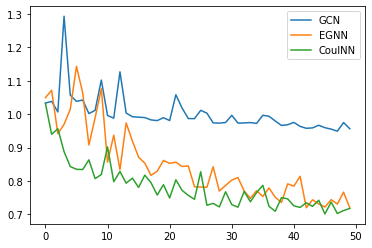

Displayed plot.
Saved to ./out/qm_0_results.pkl.


In [ ]:
# Display results, and save results in file (pretty plots in separate file)
for k, v in qm_results[0].items():
    plt.plot(v.mae, label=v.name)
plt.legend(loc="upper right")
plt.show()
print('Displayed plot.')

# Save
qm_0_file = './out/qm_0_results.pkl'
export_pickled(qm_results[0], qm_0_file)
print(f'Saved to {qm_0_file}.')

In [ ]:
qm_normal_gcn(1)
qm_egnn(1)
qm_coul(1)

Training and evaluating the following model: 
Sequential(
  (0): GCNConv(11, 32)
  (1): ELU(alpha=1.0)
  (2): GCNConv(32, 32)
  (3): ELU(alpha=1.0)
  (4): GCNConv(32, 32)
  (5): ELU(alpha=1.0)
  (6): <function global_add_pool at 0x7fe03d00b1f0>
  (7): Linear(in_features=32, out_features=1, bias=True)
)
---------------------------------------------
---- Last epoch 1/50, MAE: 4.19803
---- Last epoch 6/50, MAE: 2.47430
---- Last epoch 11/50, MAE: 2.57941
---- Last epoch 16/50, MAE: 2.42618
---- Last epoch 21/50, MAE: 2.18968
---- Last epoch 26/50, MAE: 2.09179
---- Last epoch 31/50, MAE: 2.42801
---- Last epoch 36/50, MAE: 1.94420
---- Last epoch 41/50, MAE: 2.40438
---- Last epoch 46/50, MAE: 1.79116
Done for GCN on task 1!
Training and evaluating the following model: 
EGNNModel(
  (gnn): Sequential(
    (0): EGNNLayer()
    (1): ELU(alpha=1.0)
    (2): EGNNLayer()
    (3): ELU(alpha=1.0)
    (4): EGNNLayer()
    (5): ELU(alpha=1.0)
  )
  (lin_pred): Linear(in_features=32, out_features=1

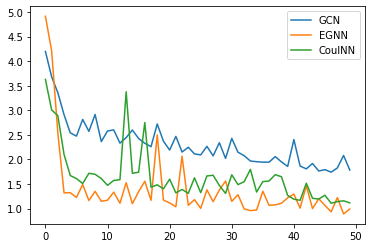

Displayed plot.
Saved to ./out/qm_1_results.pkl.


In [ ]:
for k, v in qm_results[1].items():
    plt.plot(v.mae, label=v.name)
plt.legend(loc="upper right")
plt.show()
print('Displayed plot.')

# Save
qm_1_file = './out/qm_1_results.pkl'
export_pickled(qm_results[1], qm_1_file)
print(f'Saved to {qm_1_file}.')

Training and evaluating the following model: 
Sequential(
  (0): GCNConv(11, 32)
  (1): ELU(alpha=1.0)
  (2): GCNConv(32, 32)
  (3): ELU(alpha=1.0)
  (4): GCNConv(32, 32)
  (5): ELU(alpha=1.0)
  (6): <function global_add_pool at 0x7fe03d00b1f0>
  (7): Linear(in_features=32, out_features=1, bias=True)
)
---------------------------------------------
---- Last epoch 1/50, MAE: 173.51181
---- Last epoch 6/50, MAE: 167.50087
---- Last epoch 11/50, MAE: 165.17343
---- Last epoch 16/50, MAE: 164.63649
---- Last epoch 21/50, MAE: 163.89369
---- Last epoch 26/50, MAE: 164.85897
---- Last epoch 31/50, MAE: 163.21161
---- Last epoch 36/50, MAE: 164.60527
---- Last epoch 41/50, MAE: 164.95050
---- Last epoch 46/50, MAE: 163.48295
Done for GCN on task 5!
Training and evaluating the following model: 
EGNNModel(
  (gnn): Sequential(
    (0): EGNNLayer()
    (1): ELU(alpha=1.0)
    (2): EGNNLayer()
    (3): ELU(alpha=1.0)
    (4): EGNNLayer()
    (5): ELU(alpha=1.0)
  )
  (lin_pred): Linear(in_feature

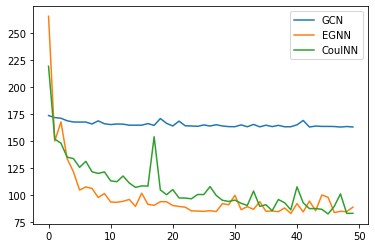

Displayed plot.
Saved to ./out/qm_5_results.pkl.


In [ ]:
qm_normal_gcn(5)
qm_egnn(5)
qm_coul(5)

# Display results, and save results in file (pretty plots in separate file)
for k, v in qm_results[5].items():
    plt.plot(v.mae, label=v.name)
plt.legend(loc="upper right")
plt.show()
print('Displayed plot.')

# Save
qm_5_file = './out/qm_5_results.pkl'
export_pickled(qm_results[5], qm_5_file)
print(f'Saved to {qm_5_file}.')

## Cora for LP

Cora is a standard *homophilic* dataset for which we want to evaluate the relative performance of $\mathsf{CoulLP}$ compared to standard LP.

In [ ]:
# Load Cora first
from torch_geometric.datasets import Planetoid


cora = Planetoid(root='./data/Cora', name='Cora', split='full')[0]
print(f'Loaded Cora, homophily = {tg.utils.homophily(cora.edge_index, cora.y):.4f}.')

Processing...


Loaded Cora, homophily = 0.8100.


Done!


In [ ]:
def run_label_prop(data, lp: nn.Module):
    """
    Runs the provided label propagation `lp`, and returns its accuracy on
    validation. 
    """
    pred = lp(data.y, data.edge_index, data.train_mask)
    pred = torch.argmax(pred, dim=-1).squeeze()
    correct = torch.count_nonzero((data.y == pred)[data.val_mask])
    tot = torch.count_nonzero(data.val_mask)
    return (correct.float() / tot.float()).item()

In [ ]:
def compare_lps_data(data, num_layers: int, alphas: Iterable[float] = [0.25, 0.5, 0.75, 1.0]):
    """
    Compares CLP and standard LP over the provided graph `data`, varying the
    number of layers up to `num_layers`, and the retention coefficient `alpha`
    in `alphas`. Returns the results in a dictionary.
    """
    assert num_layers > 0
    assert alphas
    assert not [alpha for alpha in alphas if alpha == 0.]

    models = [
        (CoulLP, 'CoulLP'),
        (LabelPropagation, 'LP'),
    ]
    store = {}
    for _, name in models:
        store[name] = {}
        for alpha in alphas:
          store[name][alpha] = []

    for alpha in alphas:
        for l in range(1, num_layers + 1):
            print(f'Evaluating for {l} layers, alpha={alpha}.')
            for model, name in models:
                acc = run_label_prop(data, model(l, alpha))
                store[name][alpha] += [acc]

    print('Done.')
    
    return store

In [ ]:
cora_results = compare_lps_data(cora, 50)

Evaluating for 1 layers, alpha=0.25.
Evaluating for 2 layers, alpha=0.25.
Evaluating for 3 layers, alpha=0.25.
Evaluating for 4 layers, alpha=0.25.
Evaluating for 5 layers, alpha=0.25.
Evaluating for 6 layers, alpha=0.25.
Evaluating for 7 layers, alpha=0.25.
Evaluating for 8 layers, alpha=0.25.
Evaluating for 9 layers, alpha=0.25.
Evaluating for 10 layers, alpha=0.25.
Evaluating for 11 layers, alpha=0.25.
Evaluating for 12 layers, alpha=0.25.
Evaluating for 13 layers, alpha=0.25.
Evaluating for 14 layers, alpha=0.25.
Evaluating for 15 layers, alpha=0.25.
Evaluating for 16 layers, alpha=0.25.
Evaluating for 17 layers, alpha=0.25.
Evaluating for 18 layers, alpha=0.25.
Evaluating for 19 layers, alpha=0.25.
Evaluating for 20 layers, alpha=0.25.
Evaluating for 21 layers, alpha=0.25.
Evaluating for 22 layers, alpha=0.25.
Evaluating for 23 layers, alpha=0.25.
Evaluating for 24 layers, alpha=0.25.
Evaluating for 25 layers, alpha=0.25.
Evaluating for 26 layers, alpha=0.25.
Evaluating for 27 lay

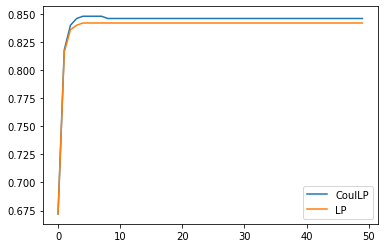

In [ ]:
for k, v in cora_results.items():
    v = v[0.5]
    plt.plot(v, label=k)
plt.legend()
plt.show()

In [ ]:
cora_results_f = './out/cora_results.pkl'
export_pickled(cora_results, cora_results_f)
print(f'Saved results to {cora_results_f}.')

Saved results to ./out/cora_results.pkl.


## Heterophilic Datasets for LP

We use the `Roman-empire` heterophilic datasets provided in Platanov et al., 2023, to evaluate CLP's performance compared to that of standard LP. For versioning reasons, we manually import `HeterophilousGraphDataset` from Torch Geometric, copy-pasting the code.

In [ ]:
import os.path as osp
from typing import Callable, Optional

import numpy as np

from torch_geometric.data import Data, InMemoryDataset, download_url


class HeterophilousGraphDataset(InMemoryDataset):
    r"""The heterophilous graphs :obj:`"Roman-empire"`,
    :obj:`"Amazon-ratings"`, :obj:`"Minesweeper"`, :obj:`"Tolokers"` and
    :obj:`"Questions"` from the `"A Critical Look at the Evaluation of GNNs
    under Heterophily: Are We Really Making Progress?"
    <https://arxiv.org/abs/2302.11640>`_ paper.

    Args:
        root (str): Root directory where the dataset should be saved.
        name (str): The name of the dataset (:obj:`"Roman-empire"`,
            :obj:`"Amazon-ratings"`, :obj:`"Minesweeper"`, :obj:`"Tolokers"`,
            :obj:`"Questions"`).
        transform (callable, optional): A function/transform that takes in an
            :obj:`torch_geometric.data.Data` object and returns a transformed
            version. The data object will be transformed before every access.
            (default: :obj:`None`)
        pre_transform (callable, optional): A function/transform that takes in
            an :obj:`torch_geometric.data.Data` object and returns a
            transformed version. The data object will be transformed before
            being saved to disk. (default: :obj:`None`)

    **STATS:**

    .. list-table::
        :widths: 10 10 10 10 10
        :header-rows: 1

        * - Name
          - #nodes
          - #edges
          - #features
          - #classes
        * - Roman-empire
          - 22,662
          - 32,927
          - 300
          - 18
        * - Amazon-ratings
          - 24,492
          - 93,050
          - 300
          - 5
        * - Minesweeper
          - 10,000
          - 39,402
          - 7
          - 2
        * - Tolokers
          - 11,758
          - 519,000
          - 10
          - 2
        * - Questions
          - 48,921
          - 153,540
          - 301
          - 2
    """
    url = ('https://github.com/yandex-research/heterophilous-graphs/raw/'
           'main/data')

    def __init__(
        self,
        root: str,
        name: str,
        transform: Optional[Callable] = None,
        pre_transform: Optional[Callable] = None,
    ):
        self.name = name.lower().replace('-', '_')
        assert self.name in [
            'roman_empire',
            'amazon_ratings',
            'minesweeper',
            'tolokers',
            'questions',
        ]

        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_dir(self) -> str:
        return osp.join(self.root, self.name, 'raw')

    @property
    def processed_dir(self) -> str:
        return osp.join(self.root, self.name, 'processed')

    @property
    def raw_file_names(self) -> str:
        return f'{self.name}.npz'

    @property
    def processed_file_names(self) -> str:
        return 'data.pt'

    def download(self):
        download_url(f'{self.url}/{self.name}.npz', self.raw_dir)

    def process(self):
        raw = np.load(self.raw_paths[0], 'r')
        x = torch.from_numpy(raw['node_features'])
        y = torch.from_numpy(raw['node_labels'])
        edge_index = torch.from_numpy(raw['edges']).t().contiguous()
        train_mask = torch.from_numpy(raw['train_masks']).t().contiguous()
        val_mask = torch.from_numpy(raw['val_masks']).t().contiguous()
        test_mask = torch.from_numpy(raw['test_masks']).t().contiguous()

        data = Data(x=x, y=y, edge_index=edge_index, train_mask=train_mask,
                    val_mask=val_mask, test_mask=test_mask)

        if self.pre_transform is not None:
            data = self.pre_transform(data)

        torch.save(self.collate([data]), self.processed_paths[0])

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}(name={self.name})'

In [ ]:
hetero = HeterophilousGraphDataset(root='./data/hetero', name='Roman-empire')
print(f'Loaded HeterophilousGraphDataset, homophily = {tg.utils.homophily(hetero.edge_index, hetero.y):.4f}.')
# Retain only first fold of the masks
hetero.train_mask = hetero.train_mask[:, 0]
hetero.val_mask = hetero.val_mask[:, 0]

Processing...


Loaded HeterophilousGraphDataset, homophily = 0.0469.


Done!


In [ ]:
hetero_results = compare_lps_data(hetero, 50)

Evaluating for 1 layers, alpha=0.25.
Evaluating for 2 layers, alpha=0.25.
Evaluating for 3 layers, alpha=0.25.
Evaluating for 4 layers, alpha=0.25.
Evaluating for 5 layers, alpha=0.25.
Evaluating for 6 layers, alpha=0.25.
Evaluating for 7 layers, alpha=0.25.
Evaluating for 8 layers, alpha=0.25.
Evaluating for 9 layers, alpha=0.25.
Evaluating for 10 layers, alpha=0.25.
Evaluating for 11 layers, alpha=0.25.
Evaluating for 12 layers, alpha=0.25.
Evaluating for 13 layers, alpha=0.25.
Evaluating for 14 layers, alpha=0.25.
Evaluating for 15 layers, alpha=0.25.
Evaluating for 16 layers, alpha=0.25.
Evaluating for 17 layers, alpha=0.25.
Evaluating for 18 layers, alpha=0.25.
Evaluating for 19 layers, alpha=0.25.
Evaluating for 20 layers, alpha=0.25.
Evaluating for 21 layers, alpha=0.25.
Evaluating for 22 layers, alpha=0.25.
Evaluating for 23 layers, alpha=0.25.
Evaluating for 24 layers, alpha=0.25.
Evaluating for 25 layers, alpha=0.25.
Evaluating for 26 layers, alpha=0.25.
Evaluating for 27 lay

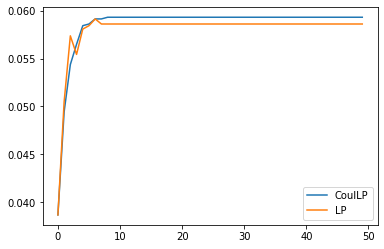

In [ ]:
for k, v in hetero_results.items():
    v = v[0.5]
    plt.plot(v, label=k)
plt.legend()
plt.show()

In [ ]:
hetero_results_f = './out/hetero_results.pkl'
export_pickled(hetero_results, hetero_results_f)
print(f'Saved results to {hetero_results_f}.')

Saved results to ./out/hetero_results.pkl.
